# Trabajo de Fin de Grado
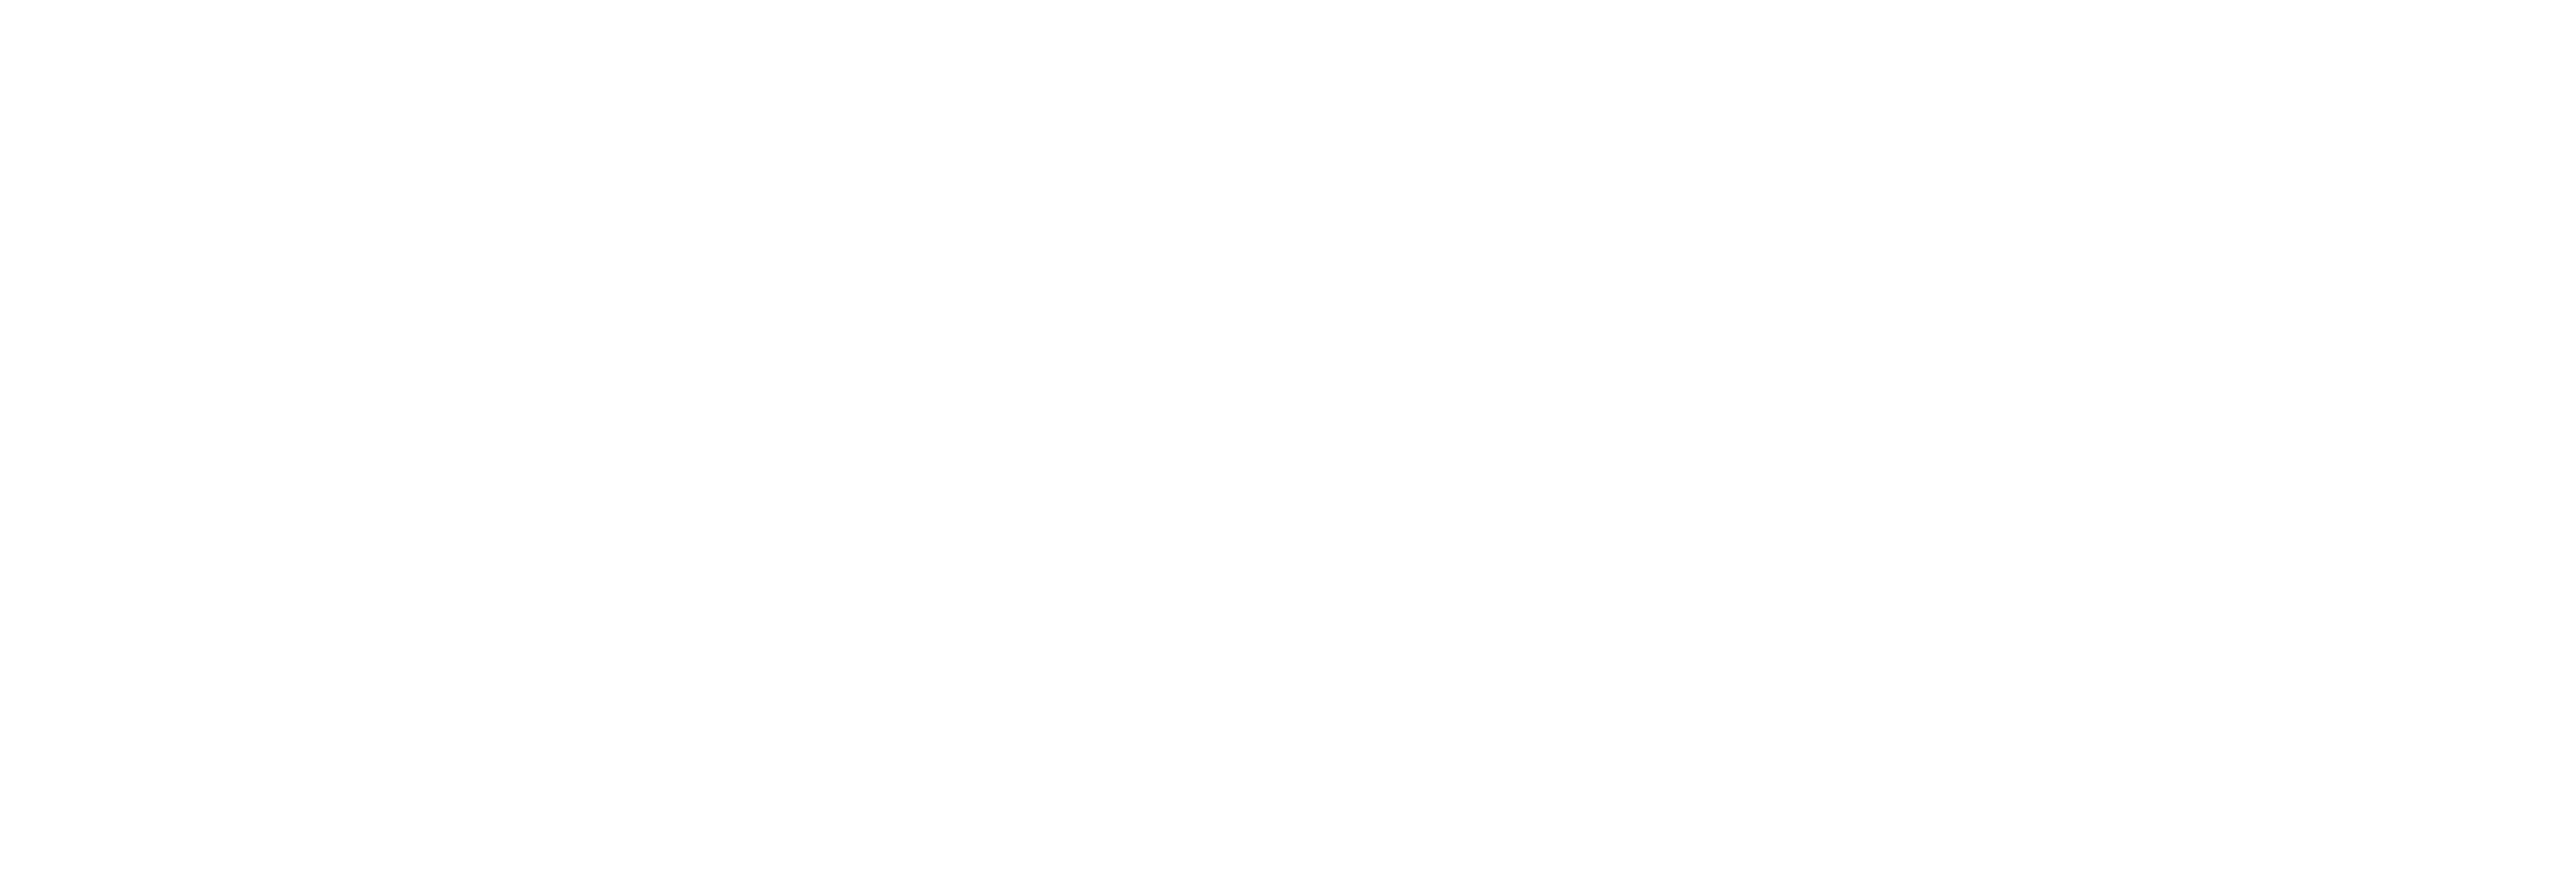

## Grado en Ingeniería Informática
### Clasificación supervisada de imágenes con redes neuornales convolucionales
##### _Pablo García García_

### Configuraciones iniciales

Para comenzar se importarán las librerías necesarias en las siguientes versiones. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics
import tensorflow as tf
import pickle

print(f"NumPy: {np.__version__}\nMatplotlib: {matplotlib.__version__}\nScikit-learn: {sk.__version__}\nTensorFlow: {tf.__version__}")

NumPy: 1.21.5
Matplotlib: 3.5.1
Scikit-learn: 0.23.2
TensorFlow: 2.13.1


Para realizar este proyecto se va a hacer uso de un equipo que cuenta con un procesador Intel Core i7-8700 y una GPU NVIDIA GTX 1060 6GB. Con ayuda de Python y TensorFlow se puede aprovechar para realizar los entrenamientos y otras operaciones de manera más rápida. Se puede observar mediante la siguiente función cómo se reconocen ambos correctamente. 

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Si se detecta una gráfica de NVIDIA compatible con CUDA, automáticamente todas las operaciones que se puedan ejecutar y paralelizar en esta, se harán de dicha manera. 

In [3]:
tf.test.is_built_with_cuda()

True

Para comenzar, se definen una serie de constantes y valores de configuración que serán de utilidad durante el proyecto. 

In [4]:
RUTA_TRAIN = "../Datasets/tfg_dataset/train"
RUTA_TEST = "../Datasets/tfg_dataset/test"
RUTA_MODELOS = "../Modelos/"
RUTA_IMG = "../Memoria/img/"

DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2
ENTRENAR = False

plt.rcParams['figure.figsize'] = [8, 8]

### Clasificación de imágenes en un conjunto cerrado de clases

Se codifican funciones para visualizar ejemplos de un dataset creado con las funciones `image_dataset_from_directory` y `flow_from_directory`. 

In [5]:
def sample_ds_dfd(ds, save = None): 
    for i, (img, label) in enumerate(ds.unbatch().take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(ds.class_names[np.argmax(label)], fontsize = 8)
        plt.axis("off")
    if save: 
        plt.savefig(f"{RUTA_IMG}{save}.pdf", format = "pdf", bbox_inches = "tight")

def sample_ds_ffd(ds, save = None): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)], fontsize = 8)
        plt.imshow(img)
        plt.axis("off")
    if save: 
        plt.savefig(f"{RUTA_IMG}{save}.pdf", format = "pdf", bbox_inches = "tight")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos). 

In [6]:
x_train, x_val = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 603 files belonging to 4 classes.


Using 483 files for training.
Using 120 files for validation.


De manera similar se realiza para los datos utilizados para evaluar el modelo. 

In [7]:
x_test = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

Found 152 files belonging to 4 classes.


Se normalizan los valores de las imágenes para facilitar el trabajo a la red. 

In [8]:
class_names = x_train.class_names
norm = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x, y: (norm(x), y))
x_val = x_val.map(lambda x, y: (norm(x), y))
x_test = x_test.map(lambda x, y: (norm(x), y))
x_train.class_names = class_names
x_val.class_names = class_names
x_test.class_names = class_names

Se muestran algunos ejemplos del dataset. 

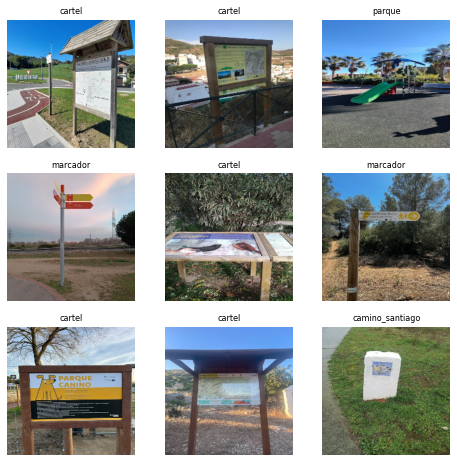

In [9]:
sample_ds_dfd(x_train)

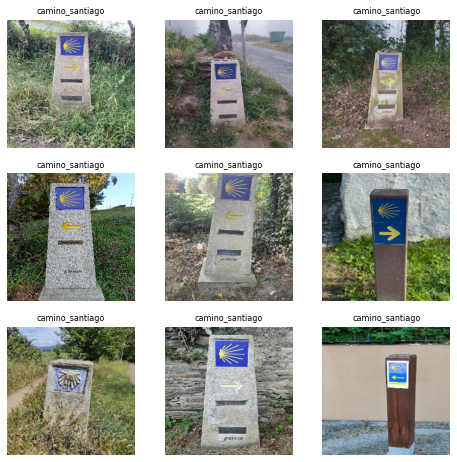

In [10]:
sample_ds_dfd(x_test)

Se crea un modelo basado en uno ya entrenado. 

In [11]:
if ENTRENAR: 
    mb = tf.keras.applications.MobileNetV2(input_shape = (DIM, DIM, 3), include_top = False, weights = "imagenet")
    mb.trainable = False
    red_mb = tf.keras.Sequential([
        mb,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_mb.summary()
    red_mb.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_mb = tf.keras.models.load_model(RUTA_MODELOS + "red_mb")
    red_mb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 2268268 (8.65 MB)
Trainable params: 10284 (40.17 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Se realiza el entrenamiento del modelo. 

In [12]:
if ENTRENAR:
    red_mb.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet")])
    red_mb.save(RUTA_MODELOS + "red_mb")

Se hacen las predicciones sobre el conjunto de test para evaluar el modelo. 

In [13]:
def predict_dataset(ds, modelo): 
    y_target = []
    y_hat = []
    y_confidence = []
    batches = len(ds)
    for batch, (img_batch, label_batch) in enumerate(ds): 
        if batch == batches: 
            break
        else: 
            for img, label in zip(img_batch, label_batch):
                y_target.append(np.argmax(label))
                y_hat.append(np.argmax(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)[0]))
                y_confidence.append(np.max(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)))
    return np.column_stack((y_target, y_hat, y_confidence)), modelo.predict(ds, verbose = 0)

Y_matrix, Y_score = predict_dataset(x_test, red_mb)

Se muestran las 9 primeras predicciones como ejemplo. 

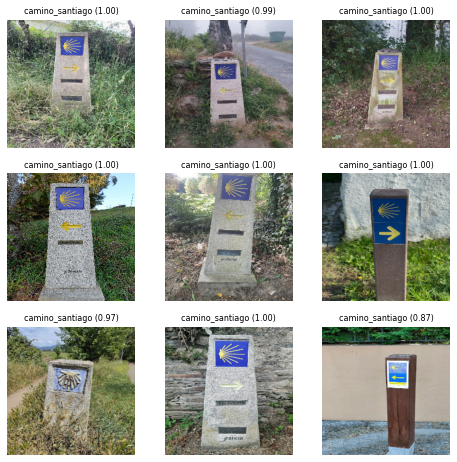

In [14]:
def sample_predict_ds_fd(ds, Y_matrix): 
    for img_batch, _ in ds.take(1):
        for i, img in enumerate(img_batch): 
            prediccion = int(Y_matrix[i, 1])
            plt.subplot(3, 3, i + 1)
            plt.title(f"{ds.class_names[prediccion]} ({Y_matrix[i, 2]:.2f})", fontsize = 8)
            plt.imshow(img.numpy())
            plt.axis("off")
            if i == 8: 
                break

sample_predict_ds_fd(x_test, Y_matrix)

### Evaluación de un clasificador (métricas)
¿Realmente ha sido un buen modelo? Se van a mostrar una serie de métricas, comenzando por la matriz de confusión

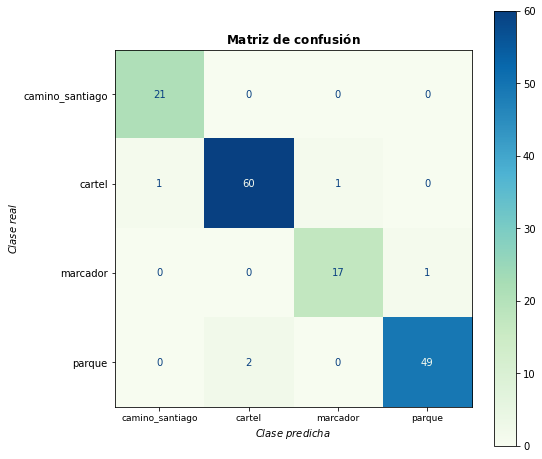

In [15]:
def matriz_confusion(ds, Y_matrix, save = None): 
    cm = sk.metrics.confusion_matrix(Y_matrix[:, 0], Y_matrix[:, 1])
    diagrama = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ds.class_names).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    diagrama.ax_.set_title(r"$\mathbf{Matriz\ de\ confusión}$")
    diagrama.ax_.set_xlabel(r"$\mathit{Clase\ predicha}$")
    diagrama.ax_.set_ylabel(r"$\mathit{Clase\ real}$")
    diagrama.ax_.tick_params(axis = "x", labelsize = 9)
    if save: 
        plt.savefig(f"{save}.pdf", format = "pdf", bbox_inches = "tight")

matriz_confusion(x_test, Y_matrix, save = RUTA_IMG + "mc_mb")

Algunas otras métricas empleadas con clasificadores: 

* **Precisión**: de todos los elementos clasificados como $C_i$, ¿cuántos realmente pertenecen a dicha clase?
$$
\mathcal{P} = P(C_i | \hat{C}_i) = \frac{P(C_i \cap \hat{C}_i)}{P(\hat{C}_i)}
$$

* **Sensibilidad**: de todos los elementos de la clase $C_i$, ¿cuántos se han clasificado como tal?
$$
\mathcal{R} = P(\hat{C}_i | C_i) = \frac{P(\hat{C}_i \cap C_i)}{P(C_i)}
$$

* $F_1-$ Score: en general, ¿cómo de bueno es el clasificador?
$$
F_1 = \frac{2}{\mathcal{P}^{-1} + \mathcal{R}^{-1}}
$$

In [16]:
def metricas_matriz_confusion(ds, Y_matrix, dict = False):
    return sk.metrics.classification_report(
                                 Y_matrix[:, 0], Y_matrix[:, 1], 
                                 target_names = ds.class_names, 
                                 digits = 3, 
                                 output_dict = dict, 
                                 zero_division = 0
                                )

mmc = metricas_matriz_confusion(x_test, Y_matrix)
print(mmc)
with open(RUTA_IMG + "mmc_mb.txt", "w") as f: 
    f.write(mmc)

                 precision    recall  f1-score   support

camino_santiago      0.955     1.000     0.977        21
         cartel      0.968     0.968     0.968        62
       marcador      0.944     0.944     0.944        18
         parque      0.980     0.961     0.970        51

       accuracy                          0.967       152
      macro avg      0.962     0.968     0.965       152
   weighted avg      0.967     0.967     0.967       152



* Coeficiente $\kappa$ de Cohen: otra manera de medir la calidad del clasificador. 

In [17]:
def kappa_cohen(Y_matrix): 
    return sk.metrics.cohen_kappa_score(Y_matrix[:, 0], Y_matrix[:, 1]).round(3)

kappa_cohen(Y_matrix)

0.952

* Curvas ROC y área AUC: en el caso de varias clases existen diferentes formas de interpretar y calcular las curvas ROC y su AUC. Predominan los algoritmos OvO y OvR. OvO consiste en realizar una media ponderada de los $2\binom{c}{2}$ posibles AUC. Es decir, para cada posible pareja de clases se considera como un caso de clasificación binaria donde se representa $P(\hat{C}_i | C_i)$ frente a $P(\hat{C}_i | C_j)$, y $P(\hat{C}_j | C_j)$ frente a $P(\hat{C}_j | C_i)$ y cada AUC obtenido se pondera respectivamente mediante $P(C_i)$ y $P(C_j)$. De esta manera el mal AUC de una pareja es proporcional al número de observaciones de las clases que compara, siendo útil para casos de clases desbalanceadas como este. 
$$
\mathcal{A}_{\text{ovo}} = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k \neq j}^c P(C_j)\mathcal{A}(C_j | C_k) = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k > j}^c P(C_j \cup C_k)(\mathcal{A}(C_j | C_k) + \mathcal{A}(C_k | C_j))
$$

In [18]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovr", average = "weighted")

0.9980944236178685

In [19]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovo", average = "weighted")

0.9982160426894775

Para hacerlo un poco más ilustrativo, se puede programar una función propia de AUC OvR donde se vean las gráficas correspondientes a las $c$ clases. 

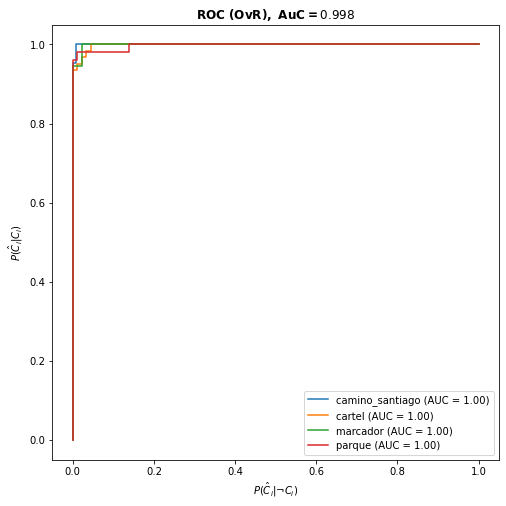

0.9980944236178684

In [20]:
def roc_auc_ovr(Y_matrix, Y_score, clases, save = None): 
    Y_ms = np.column_stack((Y_matrix[:, :-1], Y_score))
    _, ax = plt.subplots()
    auc_ovr = 0

    for i in range(Y_score.shape[1]): 
        Y_ms_temp = Y_ms.copy()
        Y_ms_temp[:, 0] = np.where(Y_ms_temp[:, 0] != i, -1, 1)
        fpr, tpr, _ = sk.metrics.roc_curve(y_true = Y_ms_temp[:, 0], y_score = Y_ms_temp[:, i + 2], pos_label = 1)
        auc = sk.metrics.auc(fpr, tpr)
        prop = np.mean(Y_ms_temp[:, 0] == 1)
        auc_ovr += auc * prop
        sk.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f"{clases[i]}").plot(ax = ax)
    
    ax.set_title(r"$\mathbf{ROC\ (OvR),\ AuC = }$" + str(auc_ovr.round(3)))
    ax.set_xlabel(r"$P(\hat{C}_i | \neg C_i)$")
    ax.set_ylabel(r"$P(\hat{C}_i | C_i)$")
    if save: 
        plt.savefig(f"{save}.pdf", format = "pdf", bbox_inches = "tight")
    plt.show()
    return auc_ovr

roc_auc_ovr(Y_matrix, Y_score, x_val.class_names, save = RUTA_IMG + "auc_mb")

Se pueden asociar todas en una única función por comodidad: 

In [21]:
def metricas_prediccion(ds, Y_matrix, Y_score, save = None): 
    matriz_confusion(ds, Y_matrix, save = f"{RUTA_IMG}mc_{save}" if save else None)
    mmc = metricas_matriz_confusion(ds, Y_matrix)
    print(mmc)
    print(f"Kappa de Cohen: {kappa_cohen(Y_matrix)}")

    if Y_score.shape[1] == 2:
        print(f"AUC: {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score[:, 1]).round(3)}")
        fpr, tpr, _ = sk.metrics.roc_curve(Y_matrix[:, 0], Y_score[:, 1])
        _, ax = plt.subplots()
        sk.metrics.RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = sk.metrics.auc(fpr, tpr)).plot(ax = ax)
        ax.set_title(r"$\mathbf{ROC}$")
        ax.set_xlabel(r"$P(\hat{C}_i | \neg C_i)$")
        ax.set_ylabel(r"$P(\hat{C}_i | C_i)$")
        if save: 
            plt.savefig(f"{RUTA_IMG}auc_{save}.pdf", format = "pdf", bbox_inches = "tight")
        plt.show()
    else:
        print(f"AUC (OvO): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovo', average = 'weighted').round(3)}")
        print(f"AUC (OvR): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovr', average = 'weighted').round(3)}")
        roc_auc_ovr(Y_matrix, Y_score, ds.class_names, save = f"{RUTA_IMG}auc_{save}" if save else None)

    if save: 
        with open(f"{RUTA_IMG}mmc_{save}.txt", "w") as f: 
            f.write(mmc)

Ahora se va a hacer una rápida comparación creando una red convolucional desde cero, y entrenándola también desde cero, para poder destacar el poder del transfer learning. 

In [22]:
if ENTRENAR: 
    red_conv = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_conv.summary()
    red_conv.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_conv = tf.keras.models.load_model(RUTA_MODELOS + "red_conv.keras")
    red_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

Entrenamos el modelo

In [23]:
if ENTRENAR: 
    red_conv.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_cnn")])
    red_conv.save(RUTA_MODELOS + "red_conv.keras")

Aplicamos las mismas métricas de evaluación

                 precision    recall  f1-score   support

camino_santiago      0.917     0.524     0.667        21
         cartel      0.812     0.903     0.855        62
       marcador      0.625     0.278     0.385        18
         parque      0.651     0.804     0.719        51

       accuracy                          0.743       152
      macro avg      0.751     0.627     0.656       152
   weighted avg      0.750     0.743     0.728       152

Kappa de Cohen: 0.61
AUC (OvO): 0.856
AUC (OvR): 0.877


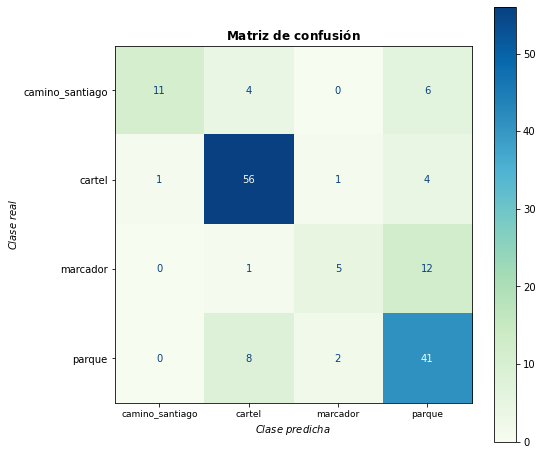

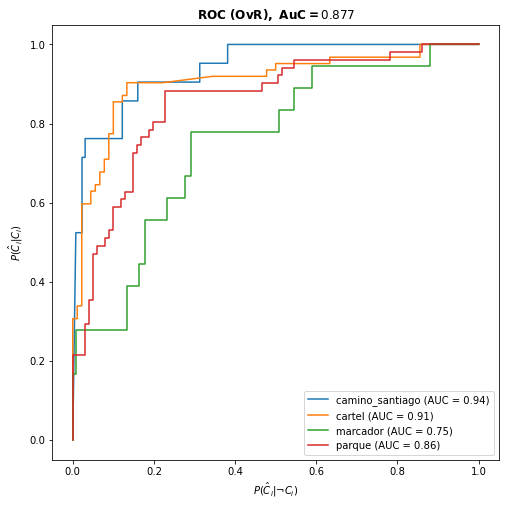

In [24]:
Y_matrix_conv, Y_score_conv = predict_dataset(x_test, red_conv)
metricas_prediccion(x_test, Y_matrix_conv, Y_score_conv, save = "conv")

Se nota que es peor, además de un claro sobreajuste en el entrenamiento, y que este es más costoso. Aún así para haberlo entrenado de cero y teniendo tan pocos datos, no está tan mal. En algunas clases, la clasificación roza la aleatoriedad. Se nota como con transfer learning, las capas convolucionales saben qué características obtener de la imagen, aquí no terminan de ser capaces y tienden a memorizar el dataset. 

Se va a proceder a la técnica del aumento de datos. Se va a crear el mismo dataset pero haciendo modificaciones sobre las imágenes, de manera que se reentrene la red aprendiendo a extraer las mismas características de imágenes similares. 

In [25]:
generador_original = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 485 images belonging to 4 classes.
Found 118 images belonging to 4 classes.
Found 485 images belonging to 4 classes.
Found 118 images belonging to 4 classes.


Se muestran las imágenes modificadas

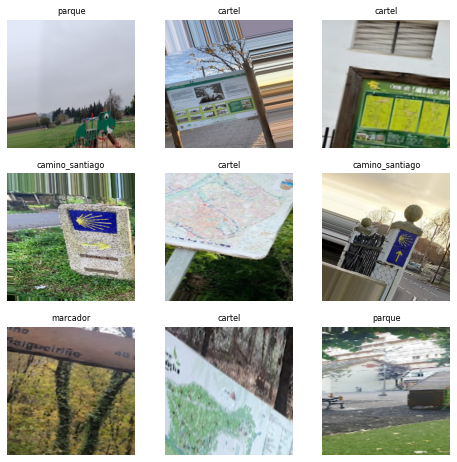

In [26]:
sample_ds_ffd(x_train_au)

Ahora se toman los modelos idénticos a los anteriores y se entrena sobre ellos con el dataset modificado para comprobar si esta técnica aporta diferencias al entrenamiento

In [27]:
if ENTRENAR: 
    mb_2 = tf.keras.applications.MobileNetV2(input_shape = (DIM, DIM, 3), include_top = False, weights = "imagenet")
    mb_2.trainable = False
    red_mb_2 = tf.keras.Sequential([
        mb_2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_mb_2.summary()
    red_mb_2.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_conv_2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    red_conv_2.summary()
    red_conv_2.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
else: 
    red_mb_2 = tf.keras.models.load_model(RUTA_MODELOS + "red_mb_2")
    red_conv_2 = tf.keras.models.load_model(RUTA_MODELOS + "red_conv_2.keras")

In [28]:
if ENTRENAR: 
    red_mb_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_augmented")])
    red_mb_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_augmented")])
    red_conv_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_conv_augmented")])
    red_conv_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_conv_augmented")])
    red_mb_2.save(RUTA_MODELOS + "red_mb_2")
    red_conv_2.save(RUTA_MODELOS + "red_conv_2.keras")

En caso de que se tengan pocos datos y malos resultados es una técnica que ayuda a mejorar. Cuidado porque también puede dar lugar a overfitting. A continuación se evalúa con las métricas empleadas previamente. 

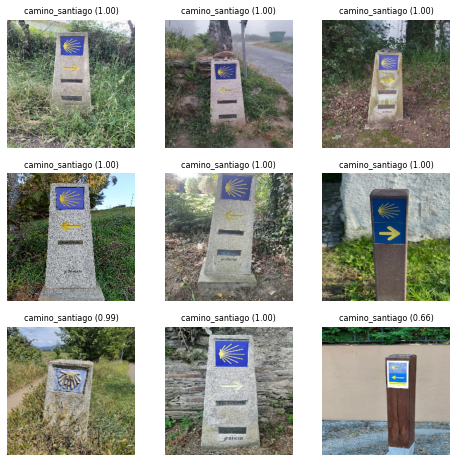

In [29]:
Y_matrix_mbau, Y_score_mbau = predict_dataset(x_test, red_mb_2)
sample_predict_ds_fd(x_test, Y_matrix_mbau)

                 precision    recall  f1-score   support

camino_santiago      0.955     1.000     0.977        21
         cartel      0.968     0.968     0.968        62
       marcador      0.944     0.944     0.944        18
         parque      0.980     0.961     0.970        51

       accuracy                          0.967       152
      macro avg      0.962     0.968     0.965       152
   weighted avg      0.967     0.967     0.967       152

Kappa de Cohen: 0.952
AUC (OvO): 0.998
AUC (OvR): 0.998


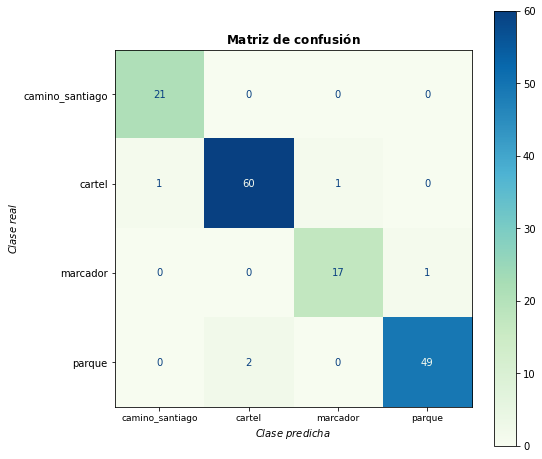

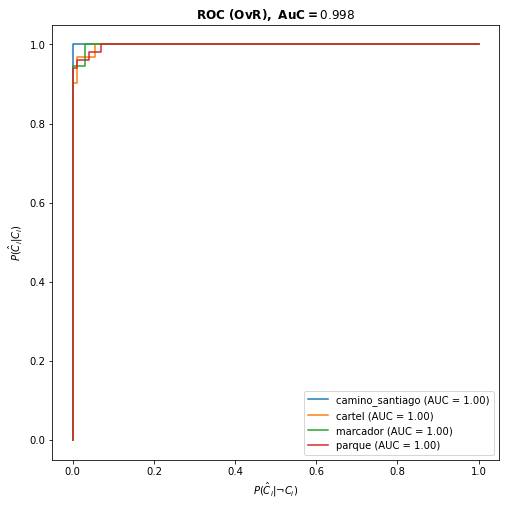

In [30]:
metricas_prediccion(x_test, Y_matrix_mbau, Y_score_mbau, save = "mbau")

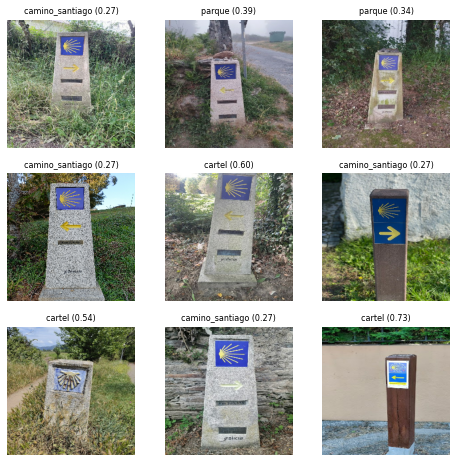

In [31]:
Y_matrix_convau, Y_score_convau = predict_dataset(x_test, red_conv_2)
sample_predict_ds_fd(x_test, Y_matrix_convau)

                 precision    recall  f1-score   support

camino_santiago      0.481     0.619     0.542        21
         cartel      0.554     1.000     0.713        62
       marcador      0.000     0.000     0.000        18
         parque      0.538     0.137     0.219        51

       accuracy                          0.539       152
      macro avg      0.393     0.439     0.368       152
   weighted avg      0.473     0.539     0.439       152

Kappa de Cohen: 0.287
AUC (OvO): 0.768
AUC (OvR): 0.777


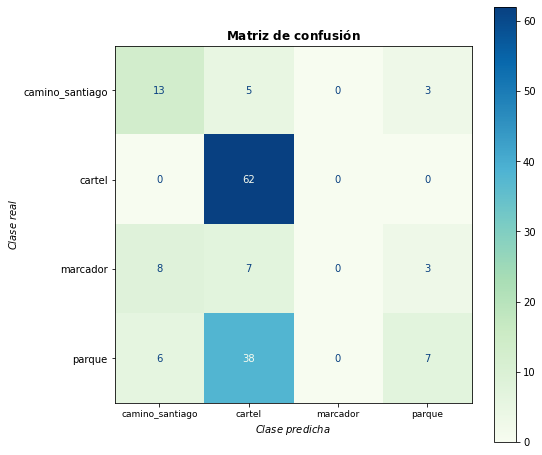

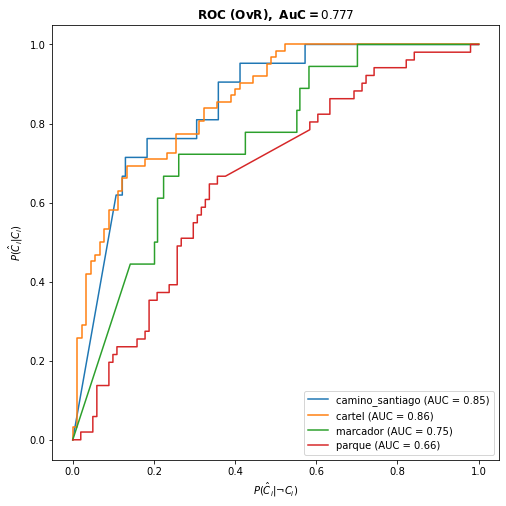

In [32]:
metricas_prediccion(x_test, Y_matrix_convau, Y_score_convau, save = "convau")

Hasta ahora, en los conjuntos de entrenamiento, validación, y test había fotos de los elementos seleccionados de diferentes partes de España. Algunos elementos como los marcadores del Camino de Santiago, varían su aspecto dependiendo de la zona de España. Lo que se va a hacer para probar la eficacia del modelo, es separar de una manera diferente las imágenes. En el conjunto de entrenamiento y validación aparecerán imágenes de diferentes partes de España, mientras en el conjunto de test, sólo habrán fotos de la ciudad de Guadalajara. 

In [33]:
RUTA_TRAIN_GU = RUTA_TRAIN.replace("tfg_dataset", "tfg_dataset_gu")
RUTA_TEST_GU = RUTA_TEST.replace("tfg_dataset", "tfg_dataset_gu")

x_train_gu, x_val_gu = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN_GU,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

x_test_gu = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST_GU,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

class_names = x_train_gu.class_names
x_train_gu = x_train_gu.map(lambda x, y: (norm(x), y))
x_val_gu = x_val_gu.map(lambda x, y: (norm(x), y))
x_test_gu = x_test_gu.map(lambda x, y: (norm(x), y))
x_train_gu.class_names = class_names
x_val_gu.class_names = class_names
x_test_gu.class_names = class_names

Found 586 files belonging to 4 classes.
Using 469 files for training.
Using 117 files for validation.
Found 102 files belonging to 4 classes.


Se utilizará la arquitectura que mejores resultados ha dado (cnn con transfer learning), y se reentrenará, pues algunas de estas imágenes se encontraban en los conjuntos de entrenamiento y validación anteriores, y evaluar sin entrenar de nuevo desde cero, sería "hacer trampa". 

In [34]:
if ENTRENAR: 
    mb_gu = tf.keras.applications.MobileNetV2(input_shape = (DIM, DIM, 3), include_top = False, weights = "imagenet")
    mb_gu.trainable = False
    red_gu = tf.keras.Sequential([
        mb_gu,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2 * len(x_train_gu.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train_gu.class_names), activation = "softmax")
    ])
    red_gu.summary()
    red_gu.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_gu.fit(x_train_gu, epochs = 25, validation_data = x_val_gu, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_guada")])
    red_mb.save(RUTA_MODELOS + "red_gu")
else: 
    red_gu = tf.keras.models.load_model(RUTA_MODELOS + "red_gu")
    red_gu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 8)                 10248     
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 2268268 (8.65 MB)
Trainable params: 10284 (40.17 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Ahora se evalúa el modelo con los datos explicados previamente

                 precision    recall  f1-score   support

camino_santiago      1.000     1.000     1.000         6
         cartel      0.974     1.000     0.987        38
       marcador      1.000     0.600     0.750         5
         parque      0.981     1.000     0.991        53

       accuracy                          0.980       102
      macro avg      0.989     0.900     0.932       102
   weighted avg      0.981     0.980     0.978       102

Kappa de Cohen: 0.966
AUC (OvO): 0.992
AUC (OvR): 0.998


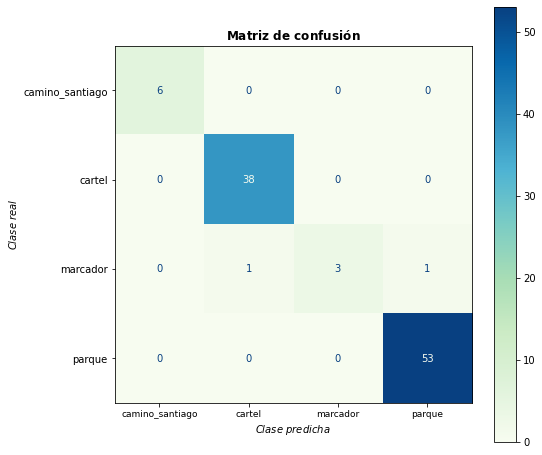

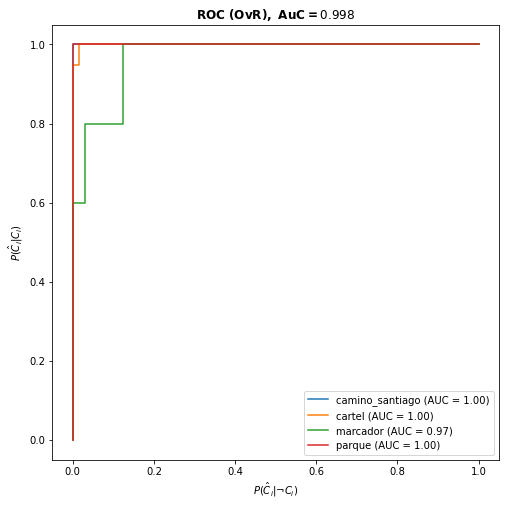

In [35]:
Y_matrix_gu, Y_score_gu = predict_dataset(x_test_gu, red_gu)
metricas_prediccion(x_test_gu, Y_matrix_gu, Y_score_gu, save = "gu")

Los resultados obtenidos han sido adecuados, sobre todo destacando el caso de los hitos del Camino de Santiago de Guadalajara, cuya forma no se parece a los que ha visto durante el entrenamiento, que pertenecen a Galicia. Se puede observar de manera clara la generalización del modelo en la siguiente figura. 

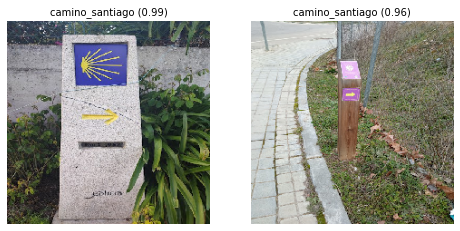

In [36]:
cs_gu = np.array(tf.keras.utils.load_img(RUTA_TEST_GU + "/camino_santiago/0.jpg", target_size = (DIM, DIM))) / 255.
cs_ga = np.array(tf.keras.utils.load_img(RUTA_TRAIN_GU + "/camino_santiago/0.jpeg", target_size = (DIM, DIM))) / 255.

pred_gu = red_gu.predict(np.expand_dims(cs_gu, axis = 0), verbose = 0)
pred_ga = red_gu.predict(np.expand_dims(cs_ga, axis = 0), verbose = 0)

plt.subplot(1, 2, 1)
plt.title(f"{x_test_gu.class_names[np.argmax(pred_ga)]} ({np.max(pred_ga):.2f})", fontsize = 10)
plt.imshow(cs_ga)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title(f"{x_test_gu.class_names[np.argmax(pred_gu)]} ({np.max(pred_gu):.2f})", fontsize = 10)
plt.imshow(cs_gu)
plt.axis("off")
plt.savefig(RUTA_IMG + "gu_vs_ga.pdf", format = "pdf", bbox_inches = "tight")

En general, los resultados obtenidos han sido buenos. En la mayoría de clases, la generalización ha sido buena, aunque no se puede establecer una conclusión muy firme, pues se tienen pocos datos de prueba. 

### Open set recognition
Ahora se va a tratar de realizar la misma tarea, pero de forma que si recibe una imagen de algo que no conoce, se descarte. Para ello se introduce una clase con imágenes de diferentes objetos. Se utilizará un modelo con la misma arquitectura que la mejor de la parte anterior. 

In [37]:
x_train_open, x_val_open = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN.replace("tfg_dataset", "tfg_dataset_otros"),
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

x_test_open = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST.replace("tfg_dataset", "tfg_dataset_otros"), 
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

class_names = x_train_open.class_names
x_train_open = x_train_open.map(lambda x, y: (norm(x), y))
x_val_open = x_val_open.map(lambda x, y: (norm(x), y))
x_test_open = x_test_open.map(lambda x, y: (norm(x), y))
x_train_open.class_names = class_names
x_val_open.class_names = class_names
x_test_open.class_names = class_names

Found 717 files belonging to 5 classes.
Using 574 files for training.
Using 143 files for validation.
Found 181 files belonging to 5 classes.


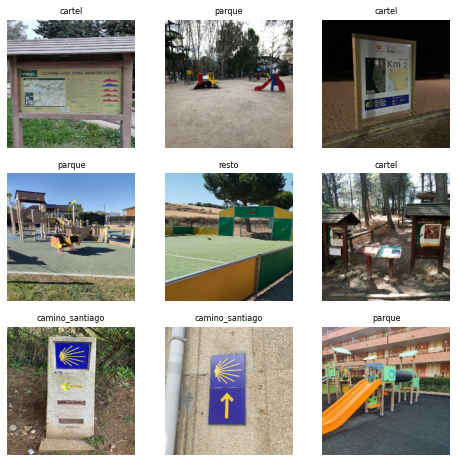

In [38]:
sample_ds_dfd(x_train_open)

Se utilizará la MobileNet con transfer learning ya que ha sido la que mejores resultados ha dado previamente

In [39]:
if ENTRENAR: 
    mb_open = tf.keras.applications.MobileNetV2(input_shape = (DIM, DIM, 3), include_top = False, weights = "imagenet")
    mb_open.trainable = False
    red_open = tf.keras.Sequential([
        mb_open,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2 * len(x_train_open.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train_open.class_names), activation = "softmax")
    ])
    red_open.summary()
    red_open.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_open.fit(x_train_open, epochs = 25, validation_data = x_val_open, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_open")])
    red_open.save(RUTA_MODELOS + "red_open")
else: 
    red_open = tf.keras.models.load_model(RUTA_MODELOS + "red_open")
    red_open.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 10)                12810     
                                                                 
 dense_13 (Dense)            (None, 5)                 55        
                                                                 
Total params: 2270849 (8.66 MB)
Trainable params: 12865 (50.25 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


                 precision    recall  f1-score   support

camino_santiago      0.875     1.000     0.933        21
         cartel      0.983     0.952     0.967        62
       marcador      1.000     0.944     0.971        18
         parque      0.961     0.961     0.961        51
          resto      0.931     0.931     0.931        29

       accuracy                          0.956       181
      macro avg      0.950     0.958     0.953       181
   weighted avg      0.958     0.956     0.956       181

Kappa de Cohen: 0.942
AUC (OvO): 0.996
AUC (OvR): 0.996


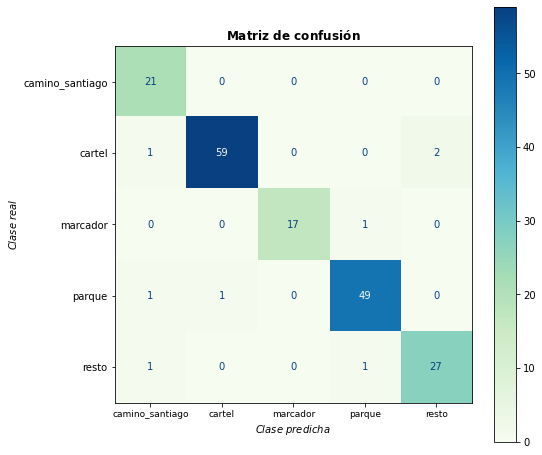

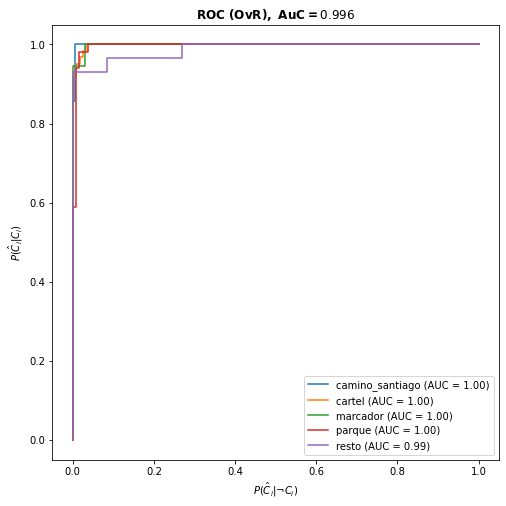

In [40]:
metricas_prediccion(x_test_open, *predict_dataset(x_test_open, red_open), save = "open_otros")

Los resultados muy buenos teniendo en cuenta que no existe relación alguna entre las imágenes de la clase "otros". 
Otra opción es crear un clasificador binario que distinga entre las cuatro clases originales y las imágenes que no pertenecen a ninguna de ellas, para después pasar aquellas que no son "otros" a uno de los clasificadores anteriores. Para realizar esto, se crea un dataset cuya clase `no_resto` tenga en los respectivos conjuntos de entrenamiento y test, las mismas imágenes que el dataset utilizado para trabajar con la red que es capaz de distinguir entre las cuatro clases originales. Para realizar dicha tarea se ha creado el script `merge_bin.py`. 

In [41]:
x_train_bin, x_val_bin = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TRAIN.replace("tfg_dataset", "tfg_dataset_bin"),
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

x_test_bin = tf.keras.utils.image_dataset_from_directory(
    directory = RUTA_TEST.replace("tfg_dataset", "tfg_dataset_bin"), 
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

class_names = x_train_bin.class_names
x_train_bin = x_train_bin.map(lambda x, y: (norm(x), y))
x_val_bin = x_val_bin.map(lambda x, y: (norm(x), y))
x_test_bin = x_test_bin.map(lambda x, y: (norm(x), y))
x_train_bin.class_names = class_names
x_val_bin.class_names = class_names
x_test_bin.class_names = class_names

Found 717 files belonging to 2 classes.


Using 574 files for training.
Using 143 files for validation.
Found 173 files belonging to 2 classes.


In [42]:
if ENTRENAR: 
    mb_bin = tf.keras.applications.MobileNetV2(input_shape = (DIM, DIM, 3), include_top = False, weights = "imagenet")
    mb_bin.trainable = False
    red_bin = tf.keras.Sequential([
        mb_bin,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2 * len(x_train_bin.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train_bin.class_names), activation = "softmax")
    ])
    red_bin.summary()
    red_bin.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy"]
    )
    red_bin.fit(x_train_bin, epochs = 25, validation_data = x_val_bin, callbacks = [tf.keras.callbacks.TensorBoard(log_dir = "../Logs/logs_mobilenet_bin")])
    red_bin.save(RUTA_MODELOS + "red_bin")
else: 
    red_bin = tf.keras.models.load_model(RUTA_MODELOS + "red_bin")
    red_bin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 2263118 (8.63 MB)
Trainable params: 5134 (20.05 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


              precision    recall  f1-score   support

    no_resto      0.979     0.986     0.983       144
       resto      0.929     0.897     0.912        29

    accuracy                          0.971       173
   macro avg      0.954     0.941     0.947       173
weighted avg      0.971     0.971     0.971       173

Kappa de Cohen: 0.895
AUC: 0.994


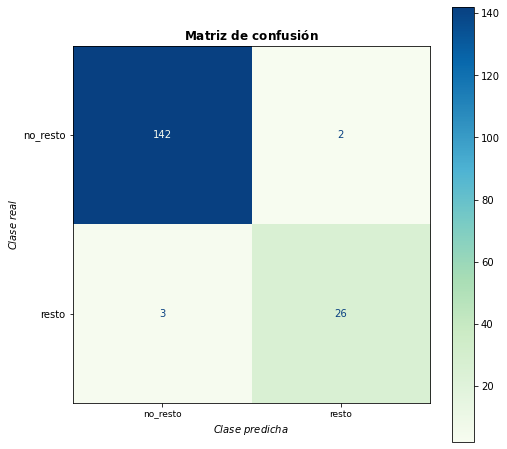

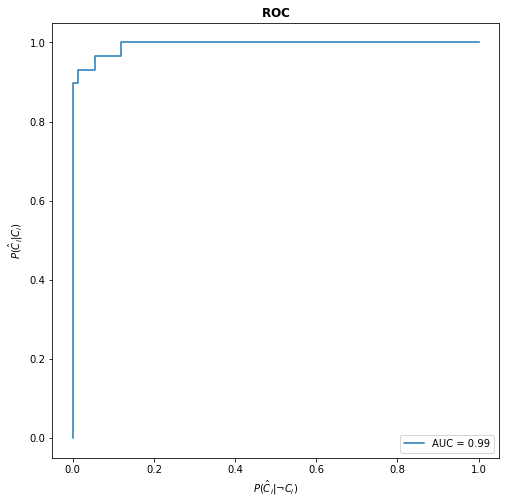

In [43]:
metricas_prediccion(x_test_bin, *predict_dataset(x_test_bin, red_bin), save = "open_bin")

Parece que en un principio, el clasificador binario no tiene problema en distinguir si una imagen de las originales es original o del resto. Utilizando esta arquitectura, se comienza realizando una predicción sobre el mismo dataset que contiene las cinco clases (las cuatro definidas y la de cualquier otra cosa) sobre el clasificador binario. A continuación, se realiza la predicción sobre un clasificador que sea capaz de distinguir entre las cuatro clases. En este primer momento, se eliminará la columna de probabilidades de la matriz $Y_m$ porque durante partes del proceso será inconsistente. 

In [44]:
Y_matrix_open_bin, Y_score_open_bin = predict_dataset(x_test_open, red_bin)
Y_matrix_open, Y_score_open = predict_dataset(x_test_open, red_mb)

Y_matrix_open_bin = np.delete(Y_matrix_open_bin, 2, axis = 1)
Y_matrix_open = np.delete(Y_matrix_open, 2, axis = 1)

Se necesitará detectar en la primera clasificación, qué imágenes han sido etiquetadas con `no_resto` y `resto`.  

In [45]:
otros_index = np.where(Y_matrix_open_bin[:, 1] == 1)

Se tiene que una imagen puede ser `no_resto` o `resto`, y si es `no_resto` entonces puede ser cualquiera de las otras cuatro clases. Entonces la matriz `Y_score_open` contienen las probabilidades $P(C_i | \lnot R)$. Por otro lado, la matriz `Y_score_open_bin` contiene las probabilidades $P(R)$ y $P(\lnot R)$. Se necesitará ajustar la matriz de probabilidades para que sea una matriz $n \times 5$ donde cada fila sume 1, y cada columna sea la probabilidad de pertenecer a una de las cinco clases (las cuatro originales y la del resto). Haciendo uso del Teorema de la probabilidad total, $$P(C_i) = P(C_i | \lnot R)P(\lnot R).$$
Habrá que multiplicar cada fila de `Y_score_open` por $P(\lnot R)$, y concatenar la segunda columna de `Y_score_open_bin` a `Y_score_open`. Esto es equivalente a multiplicar por la izquierda una matriz diagonal cuyos elementos sean la primera columna de `Y_score_open_bin`. 

$$
\begin{gathered}
    Y_s^{(3)} = \begin{pmatrix}
                    P_1(\lnot R) & 0 & \cdots & 0\\
                    0 & P_2(\lnot R) & \cdots & 0\\
                    \vdots & \vdots & \ddots & \vdots\\
                    0 & 0 & \cdots & P_n(\lnot R)
                \end{pmatrix}
                \begin{pmatrix}
                    P_1(C_1) & P_1(C_2) & \cdots & P_1(C_4)\\
                    P_2(C_1) & P_2(C_2) & \cdots & P_2(C_4)\\
                    \vdots & \vdots & \ddots & \vdots\\
                    P_n(C_1) & P_n(C_2) & \cdots & P_n(C_4)
                \end{pmatrix}\\\\
    Y_s = \left(Y_s^{(3)} \middle| Y_{s_{i2}}^{(1)}\right)
\end{gathered}
$$

In [46]:
Y_score_open = np.diag(Y_score_open_bin[:, 0]) @ Y_score_open

Una vez se ha realizado esto, habrá que añadir la columna que representa la $P(R)$. 

In [47]:
Y_score_open = np.hstack((Y_score_open, Y_score_open_bin[:, 1].reshape(-1, 1)))

De esta manera, $\displaystyle\sum_{j = 1}^m Y_{s_{ij}} = 1$, y $\displaystyle\sum_{i = 1}^n\sum_{j = 1}^m Y_{s_{ij}}= n$. 

In [48]:
Y_score_open.sum() == Y_score_open.shape[0]

True

Por otro lado, también se necesita ajustar la matriz de predicciones, de manera que si el primer clasificador etiquetaba `no_resto` (0), entonces se coloca la etiqueta del segundo clasificador, pero si el primer clasificador etiqueta como `resto` (1), entonces basta con etiquetar como `resto` (4). Previamente se había eliminado la columna de probabilidades en esta matriz para evitar inconsistencias. También hay que devolverla. 

In [49]:
Y_matrix_open[:, 1] = np.where(Y_matrix_open_bin[:, 1] == 0, Y_matrix_open[:, 1], 4)
Y_matrix_open = np.hstack((Y_matrix_open, np.max(Y_score_open, axis = 1).reshape(-1, 1)))

En estas condiciones ya se pueden mostrar las métricas empleando la arquitectura descrita. 

                 precision    recall  f1-score   support

camino_santiago      0.913     1.000     0.955        21
         cartel      0.967     0.952     0.959        62
       marcador      0.941     0.889     0.914        18
         parque      0.942     0.961     0.951        51
          resto      0.929     0.897     0.912        29

       accuracy                          0.945       181
      macro avg      0.938     0.940     0.938       181
   weighted avg      0.945     0.945     0.945       181

Kappa de Cohen: 0.927
AUC (OvO): 0.996
AUC (OvR): 0.996


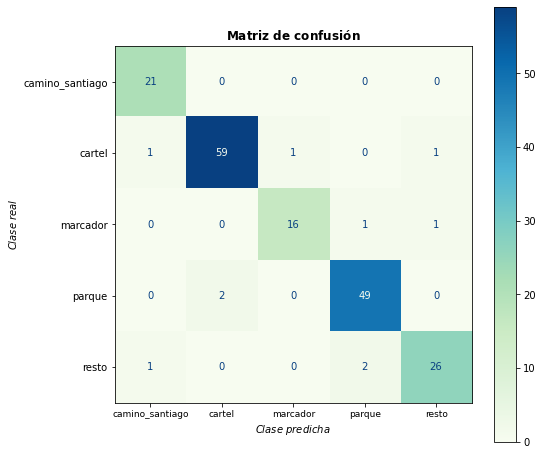

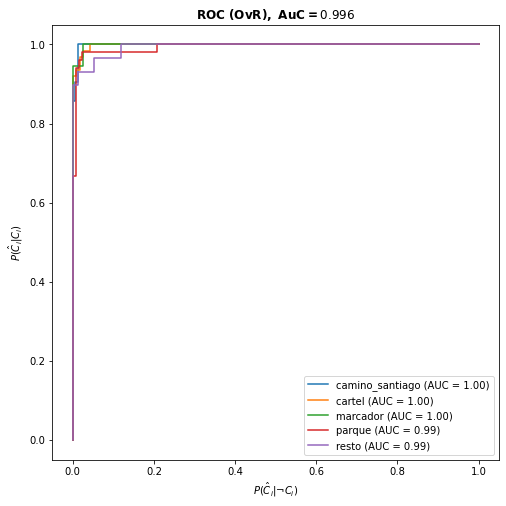

In [50]:
metricas_prediccion(x_test_open, Y_matrix_open, Y_score_open, save = "open_bin_multiple")

Comparando ambas arquitecturas, se puede notar que los resultados obtenidos son prácticamente idénticos. Quizá sea más interesante la primera de ellas ya que es más simple y obtiene resultados muy parecidos. 

### Comparativa CPU vs GPU

En este apartado se va a demostrar la eficacia de CUDA a la hora de realizar las tareas previamente mostradas. Para ello se va a realizar el entrenamiento de uno de los modelos utilizados anteriormente con diferente cantidad de épocas, lanzando dicho entrenamiento en CPU y GPU. 

In [51]:
def crear_modelo_dummy(): 
    modelo = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
        tf.keras.layers.MaxPooling2D((2, 2)), 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2 * len(x_train.class_names), activation = "relu"), 
        tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
    ])
    modelo.compile(
        optimizer = "adam",
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return modelo

def crono_entrenamiento(modelo, x_train, x_val, epochs): 
    inicio = tf.timestamp()
    modelo.fit(x_train, epochs = epochs, validation_data = x_val, verbose = 0)
    fin = tf.timestamp()
    return fin - inicio

Se evaluará el tiempo aumentando de cinco en cinco épocas, por ejemplo. 

In [52]:
if ENTRENAR: 
    n_epochs = [e for e in range(5, 55, 5)]
    dispositivos = {disp: {} for disp in ["CPU:0", "GPU:0"]}

    for epochs in n_epochs: 
        for dispositivo in dispositivos.keys(): 
            with tf.device(dispositivo):
                modelo = crear_modelo_dummy()
                tiempo = crono_entrenamiento(modelo, x_train, x_val, epochs)
            dispositivos[dispositivo][epochs] = float(tiempo)

    with open("../Logs/comp_cuda.pkl", "wb") as file: 
        pickle.dump(dispositivos, file)
else: 
    with open("../Logs/comp_cuda.pkl", "rb") as file: 
        dispositivos = pickle.load(file)

Ahora se muestra en un gráfico la comparativa. 

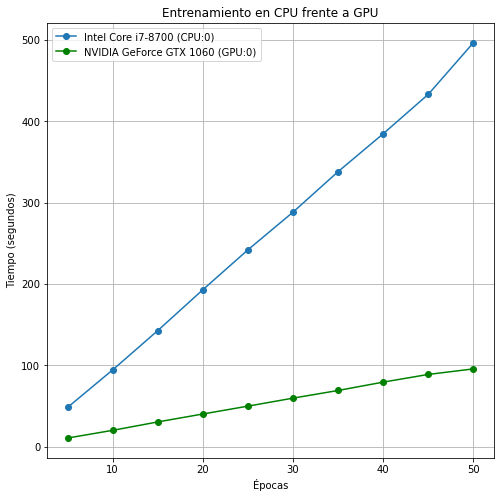

In [53]:
for nombre, tiempo in dispositivos.items():
    plt.plot(list(tiempo.keys()), list(tiempo.values()), 
             marker = "o", label = f"Intel Core i7-8700 ({nombre})" 
             if "CPU" in nombre else f"NVIDIA GeForce GTX 1060 ({nombre})", 
             color = "C0" if "CPU" in nombre else "green")

plt.title("Entrenamiento en CPU frente a GPU")
plt.xlabel("Épocas")
plt.ylabel("Tiempo (segundos)")
plt.legend()
plt.grid(True)
plt.savefig(RUTA_IMG + "comp_cuda.pdf", format = "pdf", bbox_inches = "tight")